# 📋 01 — Calidad de Datos (Data Quality)

## Objetivo del notebook

*"¿Puedo confiar en estos datos para construir un modelo?"*

Este notebook es el **primer paso del pipeline** de prediccion de precios de alquiler en Madrid. Su proposito es garantizar que los datos crudos sean fiables, coherentes y esten listos para el analisis exploratorio y el modelado posterior.

### Tareas principales

1. **Ingesta de datos** — Cargar los 3 archivos base del proyecto (microdatos de alquiler, barrios en formato JS y documento de trazabilidad).
2. **Validacion y limpieza** — Revisar columnas, nulos, duplicados y valores atipicos con reglas justificadas.
3. **Normalizacion** — Estandarizar unidades de precio (EUR/mes) y superficie (m²), y registrar las reglas en un diccionario de datos.
4. **Definicion del holdout** — Separar un conjunto de prueba final (temporal si es posible) para evaluacion honesta del modelo.
5. **Persistencia** — Guardar un dataset limpio y reproducible para los notebooks siguientes.

### Flujo general

```
Datos crudos → Ingesta → Limpieza → Normalizacion → Deduplicacion
→ Filtrado geografico → Revision de outliers → Split train/holdout
→ Dataset procesado listo para EDA
```

### Archivos de entrada

| Archivo | Descripcion |
|---------|-------------|
| `data/raw/madrid_rent_with_geolocation.csv` | Microdatos de anuncios de alquiler con geolocalizacion |
| `data/raw/alquiler_barrios_madrid_oct2025.js` | Datos de barrios de Madrid en formato JavaScript |
| `data/raw/Como_se_ha_generado_el_dataset_*.txt` | Documento de trazabilidad del dataset original |

### Artefactos generados

| Artefacto | Proposito |
|-----------|-----------|
| `artifacts/processed_rent.csv.gz` | Dataset limpio y procesado |
| `artifacts/data_dictionary.csv` | Diccionario con reglas de normalizacion aplicadas |
| `artifacts/splits/holdout_indices.npz` | Indices de train y holdout |
| `artifacts/splits/holdout_ids.csv` | IDs y asignacion de split por anuncio |
| `reports/target_selection.md` | Justificacion de la variable objetivo elegida |
| `reports/parse_numeric_report.md` | Reporte de perdida de informacion tras parseo |
| `reports/environment.txt` | Version de Python y paquetes instalados |

## 1. Configuracion inicial y dependencias

En esta seccion se importan las librerias necesarias y se establece la **semilla de reproducibilidad** (`SEED=100432070`) (Mi NIU). 

> La semilla fija garantiza que cualquier operacion aleatoria (como la separacion train/test) produzca siempre el mismo resultado, lo que hace el analisis completamente reproducible.

In [1]:
from __future__ import annotations
from pathlib import Path
import sys
import json
import hashlib
import re

import numpy as np
import pandas as pd

# --- Semilla para reproducibilidad total del pipeline ---
SEED = 100432070
np.random.seed(SEED)

def get_repo_root() -> Path:
    """Localiza la raiz del repositorio buscando .git o pyproject.toml
    hacia arriba en el arbol de directorios."""
    current = Path.cwd().resolve()
    for parent in [current] + list(current.parents):
        if (parent / ".git").exists() or (parent / "pyproject.toml").exists():
            return parent
    return current

# Resolver la raiz del proyecto y agregarla al path de importacion
ROOT = get_repo_root()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

# Importar utilidades propias del proyecto
from src.utils import haversine, make_time_splits, parse_js_barrios

## 2. Estructura de carpetas e ingesta de datos

Se crea la estructura de carpetas necesaria para el proyecto (artefactos, modelos, reportes, datos externos) y se cargan los **tres archivos fuente**:

- **Dataset principal** (`madrid_rent_with_geolocation.csv`): Microdatos de anuncios de alquiler en Madrid, scrapeados de Idealista con coordenadas geograficas.
- **Barrios** (`alquiler_barrios_madrid_oct2025.js`): Informacion de barrios de Madrid en formato JavaScript.
- **Trazabilidad** (`Como_se_ha_generado_el_dataset_*.txt`): Documento que describe como se genero el dataset original, para entender posibles sesgos y limitaciones.

In [2]:
from src.utils import haversine, parse_js_barrios, make_time_splits

# --- Crear estructura de carpetas del proyecto ---
# Se asegura que existan todas las carpetas necesarias para artefactos,
# modelos, reportes y datos externos organizados por categoria
for folder in [
    "artifacts",
    "artifacts/splits",
    "models",
    "reports",
    "data/external",
    "data/external/admin",       # Datos administrativos (limites, distritos)
    "data/external/socioeco",    # Datos socioeconomicos (renta, paro)
    "data/external/mobility",    # Datos de movilidad y transporte
    "data/external/env",         # Datos medioambientales
    "data/external/urban",       # Datos de urbanismo y equipamientos
    "data/external/timeseries",  # Series temporales de precios
    "data/external/docs",        # Documentacion de fuentes externas
]:
    (ROOT / folder).mkdir(parents=True, exist_ok=True)

# --- Rutas de los archivos de entrada ---
raw_path = ROOT / "data" / "raw" / "madrid_rent_with_geolocation.csv"
barrios_js_path = ROOT / "data" / "raw" / "alquiler_barrios_madrid_oct2025.js"
trace_path = ROOT / "data" / "raw" / "Como_se_ha_generado_el_dataset_madrid_rent_with_geolocation.csv.txt"

# --- Ingesta: lectura de los tres archivos fuente ---
rent_df = pd.read_csv(raw_path)                                             # Dataset principal de alquileres
barrios_js_text = barrios_js_path.read_text(encoding="utf-8", errors="ignore")  # Datos de barrios en JS
trace_text = trace_path.read_text(encoding="utf-8", errors="ignore")        # Documento de trazabilidad

# Vista rapida: primeras filas del dataset y extracto de trazabilidad
print(rent_df.head(3))
print(trace_text[:800])

     web_id                                              url  \
0  99440018  https://www.idealista.com/en/inmueble/99440018/   
1  99440827  https://www.idealista.com/en/inmueble/99440827/   
2  97689853  https://www.idealista.com/en/inmueble/97689853/   

                                               title    type  price  deposit  \
0               Studio flat for rent in luis cabrera  Studio    650      1.0   
1  Flat / apartment for rent in calle de Pastora ...    Flat   1750      NaN   
2  Flat / apartment for rent in calle de Gabriel ...    Flat   1490      NaN   

   private_owner    professional_name  floor_built  floor_area  ... storeroom  \
0          False  Madrid en Propiedad           30         NaN  ...     False   
1          False     PUBLICASA MADRID          148         NaN  ...     False   
2          False             roomless           65        55.0  ...     False   

   swimming_pool garden_area  \
0          False       False   
1           True       False   
2

### Resultado de la ingesta

La tabla anterior muestra las primeras filas del dataset de alquileres. Observamos columnas como `web_id` (identificador unico del anuncio), `price` (precio mensual), `floor_built`/`floor_area` (superficie), coordenadas (`lat`, `lng`), y datos categoricos como `district` y `subdistrict`.

El extracto de trazabilidad confirma que el dataset proviene de un proyecto de IA aplicado a alquileres en Madrid, siguiendo la metodologia CRISP-DM.

---

## 3. Resumen de trazabilidad

A continuacion se genera un **reporte automatico de trazabilidad** que documenta el origen de los datos. Esto es fundamental para:

- **Reproducibilidad**: Saber exactamente de donde vienen los datos.
- **Evaluacion de sesgos**: Identificar posibles limitaciones de la fuente (e.g., solo Idealista, solo un periodo temporal).
- **Auditoria**: Cumplir con buenas practicas de gobernanza de datos.

In [3]:
# === Generacion del reporte de trazabilidad ===
# Se limpia el texto de trazabilidad eliminando lineas de instalacion de paquetes,
# URLs, y otros artefactos que no aportan informacion sobre el origen de los datos.

import unicodedata

# Tokens a excluir: ruido de instalaciones pip, URLs, metadatos de paquetes
skip_tokens = (
    "!pip",
    "pip ",
    "collecting",
    "downloading",
    "requirement",
    "installing",
    "whl",
    "metadata",
    "http",
    "kb",
    "mb",
    "==",
    "attempting uninstall",
    "found existing installation",
    "successfully uninstalled",
    "successfully installed",
)
clean_lines = []
raw_lines = trace_text.splitlines()

# Caracteres invisibles que pueden interferir en la lectura del texto
null_char = chr(0)
cr_char = chr(13)
bom_char = chr(0xFEFF)
para_char = chr(0x00B6)
newline = chr(10)

# Filtrar lineas irrelevantes y normalizar caracteres especiales
for line in raw_lines:
    line = line.replace(bom_char, "").replace(null_char, "").replace(cr_char, "").replace(para_char, "")
    low = line.strip().lower()
    if any(token in low for token in skip_tokens):
        continue
    if not low:
        continue
    # Parar al encontrar bloques de codigo (imports, comentarios Python)
    if low.startswith("import ") or low.startswith("#"):
        if clean_lines:
            break
        continue
    # Normalizar a ASCII para evitar problemas de codificacion en reportes
    line = unicodedata.normalize("NFKD", line).encode("ascii", "ignore").decode("ascii")
    clean_lines.append(line)

# Construir el resumen de trazabilidad (primeras 12 lineas limpias)
trace_summary = newline.join(clean_lines[:12])

# Detectar automaticamente referencias a fuentes en el texto original
text_low = newline.join(raw_lines).lower()
context_lines = []
if "kaggle" in text_low:
    context_lines.append("- Fuente base referenciada en Kaggle (dataset de alquileres Madrid).")
if "google maps" in text_low or "geolocaliz" in text_low:
    context_lines.append("- Geolocalizacion completada con script externo y Google Maps API (segun trazabilidad).")
if "madrid_rent_geolocation.py" in text_low:
    context_lines.append("- Script de geolocalizacion mencionado: madrid_rent_geolocation.py.")

# Bloques narrativos para completar el reporte
extra = [
    "",
    "Contexto del origen:",
]
if context_lines:
    extra.extend(context_lines)
else:
    extra.append("- No se detectaron referencias adicionales en el texto.")
extra += [
    "",
    "Supuestos y riesgos:",
    "- Posibles duplicados entre fuentes; se deduplica por id/fingerprint.",
    "- Temporalidad sin año; se asume 2025 para ordenar y se documenta la limitacion.",
    "- Coordenadas/superficie pueden contener errores; se aplican filtros y parseo robusto.",
    "",
    "Implicaciones para limpieza/validacion:",
    "- Filtrado geografico por bbox/radio y percentiles.",
    "- Preprocesado solo con train via Pipeline/ColumnTransformer.",
]

# Guardar el reporte de trazabilidad en disco
trace_report = ROOT / "reports" / "traceability_summary.md"
trace_report.write_text(
    "## Resumen de trazabilidad" + newline + newline + trace_summary + newline + newline.join(extra) + newline,
    encoding="utf-8",
)

1199

## 4. Inspeccion del esquema de datos

Antes de cualquier transformacion, es esencial conocer el **perfil de cada columna**: tipo de dato, porcentaje de valores nulos y ejemplos representativos. Esta tabla nos permite identificar rapidamente:

- **Columnas con alta tasa de nulos** que podrian necesitar imputacion o eliminacion.
- **Tipos de datos incorrectos** (e.g., numeros almacenados como texto).
- **Columnas candidatas** para ser la variable objetivo, predictores o identificadores.

In [4]:
# === Tabla resumen del esquema de datos ===
# Para cada columna del dataset: tipo, porcentaje de nulos y 5 ejemplos reales.
# Esto permite una vision rapida de la calidad y estructura de los datos.
summary = []
for col in rent_df.columns:
    series = rent_df[col]
    summary.append({
        "column": col,
        "dtype": str(series.dtype),
        "null_pct": round(series.isna().mean() * 100, 2),  # Porcentaje de valores faltantes
        "examples": series.dropna().astype(str).head(5).tolist(),  # 5 valores de ejemplo
    })
summary_df = pd.DataFrame(summary)
summary_df.head()

,column,dtype,null_pct,examples
0,web_id,int64,0.0,"[99440018, 99440827, 97689853, 97689852, 99399..."
1,url,object,0.0,[https://www.idealista.com/en/inmueble/9944001...
2,title,object,0.0,"[Studio flat for rent in luis cabrera, Flat / ..."
3,type,object,0.0,"[Studio, Flat, Flat, Flat, Flat]"
4,price,int64,0.0,"[650, 1750, 1490, 900, 950]"


---

## 5. Normalizacion de columnas numericas clave

Los datos crudos pueden contener precios y superficies en formatos inconsistentes (con simbolos de euro, separadores de miles, m², etc.). Aqui se implementa un **parser robusto** que:

1. **Detecta automaticamente** las columnas de precio, superficie y precio por m².
2. **Limpia y convierte** valores de texto a números, manejando multiples formatos de separadores (`1.234,56` o `1,234.56`).
3. **Aplica un fallback** con regex si la perdida de informacion supera el 30%.
4. **Registra todo** en un diccionario de datos y un reporte de parseo.

### Estrategia de superficie

Se prioriza `floor_area` (superficie util) sobre `floor_built` (superficie construida). Cuando `floor_area` no esta disponible, se usa `floor_built` como fallback y se marca con un flag (`surface_is_built`) para que los modelos puedan tenerlo en cuenta.

> **¿Por que lo hago así?** Porque la superficie construida suele ser un 10-20% mayor que la util, lo que puede afectar al calculo de precio por m².

In [5]:
# === Normalizacion de columnas clave: precio, superficie, precio/m2 ===

euro = chr(8364)   # Simbolo del euro: €
sup2 = chr(178)    # Superindice 2: ²

# --- Parser robusto para valores numericos con separadores mixtos ---
# Maneja formatos europeos (1.234,56) y anglosajones (1,234.56),
# ademas de simbolos de moneda y unidades de superficie.

def parse_numeric(value):
    """Convierte un valor de texto a numero, manejando multiples formatos."""
    if value is None or (isinstance(value, float) and np.isnan(value)):
        return np.nan
    if isinstance(value, (int, float, np.integer, np.floating)):
        return float(value)
    text = str(value).strip().lower()
    if text in {"", "nan", "none", "null"}:
        return np.nan
    # Eliminar simbolos de moneda y unidades
    text = text.replace(euro, "").replace("eur", "")
    text = text.replace(f"m{sup2}", "m2").replace("m^2", "m2")
    text = re.sub(r"[^0-9,\.\-]", "", text)
    # Normalizar separadores: formato europeo 1.234,56 -> 1234.56
    if text.count(",") and text.count("."):
        text = text.replace(".", "")
        text = text.replace(",", ".")
    elif text.count(",") and not text.count("."):
        text = text.replace(",", ".")
    try:
        return float(text)
    except ValueError:
        return np.nan


def pick_first(candidates, preferred=None):
    """Selecciona una columna candidata, priorizando un nombre conocido."""
    if preferred and preferred in candidates:
        return preferred
    return candidates[0] if candidates else None


def _parse_with_report(series: pd.Series, col_name: str, standard: str):
    """Aplica el parseo numerico y mide la perdida de informacion.
    Si se pierde mas del 30%, aplica un fallback con regex."""
    parsed = series.apply(parse_numeric)
    raw_non_null = series.notna().sum()
    parsed_non_null = parsed.notna().sum()
    loss_pct = 0.0 if raw_non_null == 0 else round((raw_non_null - parsed_non_null) / raw_non_null * 100, 2)
    fallback_used = False
    # Fallback: si el parseo principal pierde >30% de datos, usar regex mas flexible
    if raw_non_null > 0 and loss_pct > 30:
        extracted = series.astype(str).str.extract(r"(-?[0-9]+(?:[\.,][0-9]+)?)")[0]
        extracted = extracted.str.replace(",", ".", regex=False)
        fallback = pd.to_numeric(extracted, errors="coerce")
        fallback_non_null = fallback.notna().sum()
        fallback_loss_pct = 0.0 if raw_non_null == 0 else round((raw_non_null - fallback_non_null) / raw_non_null * 100, 2)
        if fallback_loss_pct < loss_pct:
            parsed = fallback
            loss_pct = fallback_loss_pct
            fallback_used = True
    # Registrar metricas de parseo para el reporte final
    parse_report.append({
        "column": col_name,
        "standard": standard,
        "loss_pct": loss_pct,
        "fallback_used": fallback_used,
        "raw_non_null": int(raw_non_null),
    })
    return parsed

# --- Deteccion automatica de columnas candidatas por patron de nombre ---
lower_cols = {col: col.lower() for col in rent_df.columns}
price_candidates = [col for col, low in lower_cols.items() if re.search(r"price|precio", low) and not re.search(r"m2|m\^2", low)]
price_m2_candidates = [col for col, low in lower_cols.items() if re.search(r"price|precio", low) and re.search(r"m2|m\^2", low)]
surface_candidates = [
    col for col, low in lower_cols.items()
    if re.search(r"surface|superficie|area|m2|metros", low)
    and not re.search(r"price|precio", low)
]

# Seleccionar la mejor columna candidata para cada variable
price_col = pick_first(price_candidates, preferred="price")
price_m2_col = pick_first(price_m2_candidates)
surface_col = pick_first(surface_candidates, preferred="floor_area")

rules = []        # Reglas de normalizacion para el diccionario de datos
parse_report = []  # Metricas de parseo para el reporte

# --- Parsear precio mensual ---
if price_col:
    rent_df["price"] = _parse_with_report(rent_df[price_col], price_col, "price")
    rules.append({"column": price_col, "standard": "price", "rule": "parsed_numeric_eur_month"})

# --- Parsear superficie (m2) ---
# Estrategia: usar floor_area como base, con fallback a floor_built
if surface_col:
    rent_df["surface_m2"] = _parse_with_report(rent_df[surface_col], surface_col, "surface_m2")
    rules.append({"column": surface_col, "standard": "surface_m2", "rule": "parsed_numeric_m2"})

if "floor_built" in rent_df.columns:
    floor_built_numeric = pd.to_numeric(rent_df["floor_built"], errors="coerce")
    if "surface_m2" in rent_df.columns:
        # Rellenar NaN de surface_m2 con floor_built y marcar con flag
        # (la superficie construida suele ser 10-20% mayor que la util)
        surface_was_na = rent_df["surface_m2"].isna()
        rent_df["surface_m2"] = rent_df["surface_m2"].fillna(floor_built_numeric)
        rent_df["surface_is_built"] = surface_was_na & rent_df["surface_m2"].notna()
        filled_actual = surface_was_na.sum() - rent_df["surface_m2"].isna().sum()
        print(f"surface_m2: {filled_actual} NaN rellenados con floor_built (flag: surface_is_built)")
        rules.append({"column": "floor_built", "standard": "surface_m2", "rule": "fallback_fillna_floor_built"})
    else:
        rent_df["surface_m2"] = floor_built_numeric
        rules.append({"column": "floor_built", "standard": "surface_m2", "rule": "primary_from_floor_built"})

# --- Parsear precio por m2 (si existe columna original) ---
if price_m2_col:
    rent_df["price_m2"] = _parse_with_report(rent_df[price_m2_col], price_m2_col, "price_m2")
    rules.append({"column": price_m2_col, "standard": "price_m2", "rule": "parsed_numeric_eur_m2"})

# --- Derivar price_m2 si no existe pero hay precio y superficie ---
if "price_m2" not in rent_df.columns and "price" in rent_df.columns and "surface_m2" in rent_df.columns:
    rent_df["price_m2"] = rent_df["price"] / rent_df["surface_m2"].replace({0: np.nan})
    rules.append({"column": "derived", "standard": "price_m2", "rule": "price / surface_m2"})

# --- Guardar diccionario de datos y reporte de parseo ---
pd.DataFrame(rules).to_csv(ROOT / "artifacts" / "data_dictionary.csv", index=False)

report_lines = ["## Perdida de informacion tras parseo", ""]
for row in parse_report:
    report_lines.append(f"- {row['column']}: {row['loss_pct']}% (fallback={row['fallback_used']})")
report_lines.append("")
report_lines.append("## Fallback aplicado")
for row in parse_report:
    if row["fallback_used"]:
        report_lines.append(f"- {row['column']}: fallback mejoro la perdida")
if not any(row["fallback_used"] for row in parse_report):
    report_lines.append("- Ninguno")

(ROOT / "reports" / "parse_numeric_report.md").write_text("\n".join(report_lines), encoding="utf-8")

surface_m2: 5291 NaN rellenados con floor_built (flag: surface_is_built)


137

In [6]:
# Seleccion de target (price / price_m2) y evidencia

derived_price_m2 = price_m2_col is None and "price" in rent_df.columns and "surface_m2" in rent_df.columns
price_m2_source = price_m2_col or ("derived_from_price_surface" if derived_price_m2 else None)

euro = chr(8364)
sup2 = chr(178)

selection_report = ROOT / "reports" / "target_selection.md"
with selection_report.open("w", encoding="utf-8") as handle:
    handle.write("# Seleccion de target\n\n")
    handle.write(f"- Columna precio mensual candidata: {price_col}\n")
    handle.write(f"- Columna superficie candidata: {surface_col}\n")
    handle.write(f"- Columna precio m2 candidata: {price_m2_source}\n\n")
    if price_col is None:
        handle.write("- No se encontro una columna clara de precio mensual.\n")
    if surface_col is None:
        handle.write("- No se encontro una columna clara de superficie.\n")
    if price_m2_col is None:
        if derived_price_m2:
            handle.write("- Se derivo price_m2 desde precio mensual y superficie.\n")
        else:
            handle.write("- No se encontro una columna clara de precio por m2.\n")

    # Analisis de diferenciacion euros/mes vs euros/m2 en columna de precio
    handle.write("\n## Diferenciacion precio/mes vs precio/m2\n\n")
    if price_col:
        raw_price = rent_df[price_col].astype(str).str.lower()
        raw_norm = raw_price.str.replace(euro, "", regex=False).str.replace(sup2, "2", regex=False)
        # Detectar patrones de euros/m2
        pattern_m2 = raw_norm.str.contains(r"m2|m\^2|/m", regex=True, na=False)
        pattern_mes = raw_norm.str.contains(r"mes|month|/mes", regex=True, na=False)
        n_m2 = int(pattern_m2.sum())
        n_mes = int(pattern_mes.sum())
        n_pure_numeric = int((~pattern_m2 & ~pattern_mes).sum())

        handle.write(f"- Filas con patron euros/m2 (m2, m^2, /m): {n_m2}\n")
        handle.write(f"- Filas con patron euros/mes (mes, month): {n_mes}\n")
        handle.write(f"- Filas sin indicador de unidad (numerico puro): {n_pure_numeric}\n")

        if n_m2 > 0:
            handle.write(f"- AVISO: {n_m2} filas en {price_col} contienen indicios de precio por m2.\n")
            handle.write("  Estas filas podrian requerir tratamiento diferenciado o exclusion del target principal.\n")
        else:
            handle.write("- No se detectaron strings tipo m2 en la columna de precio.\n")

        handle.write("- Conclusion: Se asume que price representa euros/mes (alquiler mensual).\n")
        handle.write("  price_m2 se calcula como price / surface_m2 para analisis por m2.\n")
    else:
        handle.write("- No hay columna de precio para analizar.\n")

    if price_col:
        stats = rent_df["price"].describe(percentiles=[0.1, 0.5, 0.9]).to_dict()
        handle.write("\n## Estadisticas rapidas price\n")
        for key, value in stats.items():
            handle.write(f"- {key}: {value}\n")

In [7]:
# Duplicados defendibles
if "web_id" in rent_df.columns:
    dedup_key = "web_id"
elif "id" in rent_df.columns:
    dedup_key = "id"
elif "url" in rent_df.columns:
    dedup_key = "url"
else:
    # Construir fingerprint con columnas numericas y categoricas cortas
    lat_col = next((c for c in rent_df.columns if "lat" in c.lower()), None)
    lon_col = next((c for c in rent_df.columns if "lon" in c.lower() or "lng" in c.lower()), None)
    numeric_cols = [
        c for c in rent_df.columns
        if c not in ["price", "price_m2"] and pd.api.types.is_numeric_dtype(rent_df[c])
    ]
    obj_cols = [c for c in rent_df.columns if rent_df[c].dtype == "object"]
    short_obj_cols = []
    for col in obj_cols:
        sample = rent_df[col].dropna().astype(str)
        if sample.empty:
            continue
        avg_len = sample.str.len().mean()
        unique_ratio = sample.nunique() / len(sample)
        if avg_len <= 50 and unique_ratio <= 0.8:
            short_obj_cols.append(col)
    core_cols = numeric_cols + short_obj_cols
    temp_df = rent_df[core_cols].copy() if core_cols else rent_df.copy()
    if lat_col and lon_col:
        temp_df[lat_col] = rent_df[lat_col].round(5)
        temp_df[lon_col] = rent_df[lon_col].round(5)
    hash_source = temp_df.fillna("NA").astype(str).agg("|".join, axis=1)
    rent_df["listing_fingerprint"] = hash_source.apply(lambda x: hashlib.md5(x.encode()).hexdigest())
    dedup_key = "listing_fingerprint"

before = len(rent_df)
rent_df = rent_df.drop_duplicates(subset=[dedup_key])
after = len(rent_df)
print(f"Duplicados removidos: {before - after} (dedup_key={dedup_key})")

Duplicados removidos: 0 (dedup_key=web_id)


In [8]:
# Filtrado geografico: bbox + distancia al centro
center_lat, center_lon = 40.4168, -3.7038
lat_col = next((c for c in rent_df.columns if "lat" in c.lower()), None)
lon_col = next((c for c in rent_df.columns if "lon" in c.lower() or "lng" in c.lower()), None)

if lat_col and lon_col:
    # Distancia al centro y recorte por percentil alto
    rent_df["distance_center_km"] = rent_df.apply(
        lambda row: haversine(center_lat, center_lon, row[lat_col], row[lon_col]), axis=1
    )
    max_km = min(30, rent_df["distance_center_km"].quantile(0.995))
    rent_df = rent_df[rent_df["distance_center_km"] <= max_km]

    # Filtro bbox robusto (0.5%-99.5%)
    lat_low, lat_high = rent_df[lat_col].quantile([0.005, 0.995])
    lon_low, lon_high = rent_df[lon_col].quantile([0.005, 0.995])
    rent_df = rent_df[(rent_df[lat_col].between(lat_low, lat_high)) & (rent_df[lon_col].between(lon_low, lon_high))]

# Reindex tras filtros para alinear indices con el holdout
rent_df = rent_df.reset_index(drop=True)


In [9]:
# Outliers basicos (IQR) para price y surface_m2
outlier_report = {}
for col in ["price", "surface_m2"]:
    if col in rent_df.columns:
        q1, q3 = rent_df[col].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        outlier_pct = ((rent_df[col] < lower) | (rent_df[col] > upper)).mean() * 100
        outlier_report[col] = round(outlier_pct, 2)

outlier_report


{'price': np.float64(5.81), 'surface_m2': np.float64(7.17)}

In [10]:
# Holdout final fijo (temporal si hay fecha fiable)
from sklearn.model_selection import train_test_split
import json

HOLDOUT_TEST_SIZE = 0.2
GAP_DAYS = 7

# Detectar columna temporal

date_keys = ("date", "fecha", "update", "scrape", "publica")
date_cols = [c for c in rent_df.columns if any(k in c.lower() for k in date_keys)]
temporal_ok = False
date_col = None
assumed_year = None
if date_cols:
    date_col = date_cols[0]
    date_series = rent_df[date_col].dropna().astype(str).str.strip()
    if not date_series.empty:
        has_year = date_series.str.contains(r"\d{4}")
        day_month_only = date_series.str.match(r"^\d{1,2}\s+[A-Za-z]+$")
        if day_month_only.all() and not has_year.any():
            # Derive year from data context instead of hardcoding
            assumed_year = pd.Timestamp.now().year
            parsed = pd.to_datetime(
                date_series + f" {assumed_year}",
                errors="coerce",
                format="%d %B %Y",
            )
            if parsed.notna().sum() == 0:
                temporal_ok = False
                (ROOT / "reports" / "temporal_limitations.md").write_text(
                    f"La columna {date_col} no incluye anio y no se pudo parsear con anio asumido.",
                    encoding="utf-8",
                )
            else:
                temporal_ok = True
                rent_df.loc[parsed.index, date_col] = parsed
                (ROOT / "reports" / "temporal_limitations.md").write_text(
                    f"La columna {date_col} solo trae dia/mes; se asume anio {assumed_year} para ordenar temporalmente.",
                    encoding="utf-8",
                )
        else:
            temporal_ok = True
            rent_df[date_col] = pd.to_datetime(rent_df[date_col], errors="coerce", format="mixed")
else:
    (ROOT / "reports" / "temporal_limitations.md").write_text(
        "No se detectaron columnas temporales fiables para holdout temporal.",
        encoding="utf-8",
    )

# Split holdout (temporal o aleatorio)
if temporal_ok:
    train_idx, test_idx = make_time_splits(
        rent_df,
        date_col,
        test_size=HOLDOUT_TEST_SIZE,
        seed=SEED,
        gap_days=GAP_DAYS,
    )
else:
    train_idx, test_idx = train_test_split(rent_df.index, test_size=HOLDOUT_TEST_SIZE, random_state=SEED)

# Guardar indices de split
np.savez(ROOT / "artifacts" / "splits" / "holdout_indices.npz", train_idx=train_idx, test_idx=test_idx)

split_config = {
    "date_col": date_col,
    "temporal_ok": bool(temporal_ok),
    "test_size": HOLDOUT_TEST_SIZE,
    "gap_days": GAP_DAYS if temporal_ok else 0,
    "assumed_year": assumed_year,
}
(ROOT / "artifacts" / "splits" / "split_config.json").write_text(
    json.dumps(split_config, ensure_ascii=False, indent=2),
    encoding="utf-8",
)

# Guardar ids/fingerprint por split
# Spec: columna debe llamarse "fingerprint" (contenido = web_id, url o hash segun exista)
id_col = None
if "web_id" in rent_df.columns:
    id_col = "web_id"
elif "id" in rent_df.columns:
    id_col = "id"
elif "url" in rent_df.columns:
    id_col = "url"
elif "listing_fingerprint" in rent_df.columns:
    id_col = "listing_fingerprint"

if id_col:
    split_labels = pd.Series("train", index=rent_df.index)
    split_labels.loc[test_idx] = "holdout"
    holdout_ids = pd.DataFrame({
        "fingerprint": rent_df[id_col].values,
        "split": split_labels.values,
    })
    holdout_ids.to_csv(ROOT / "artifacts" / "splits" / "holdout_ids.csv", index=False)
    print(f"holdout_ids.csv guardado con columna 'fingerprint' (fuente: {id_col})")

holdout_ids.csv guardado con columna 'fingerprint' (fuente: web_id)


In [11]:
# Parsear barriosMadrid y guardar artefacto
barrios = parse_js_barrios(barrios_js_text)
if barrios:
    with (ROOT / "artifacts" / "barriosMadrid.json").open("w", encoding="utf-8") as handle:
        json.dump(barrios, handle, ensure_ascii=False, indent=2)


In [12]:
# Guardar artefacto procesado
out_path = ROOT / "artifacts" / "processed_rent.parquet"
try:
    rent_df.to_parquet(out_path, index=False)
except Exception:
    out_path = ROOT / "artifacts" / "processed_rent.csv.gz"
    rent_df.to_csv(out_path, index=False, compression="gzip")

# Registrar entorno (python -V y pip freeze)
import subprocess
import sys as _sys
py_version = subprocess.check_output([_sys.executable, "-V"]).decode().strip()
reqs = subprocess.check_output([_sys.executable, "-m", "pip", "freeze"]).decode().strip()
with (ROOT / "reports" / "environment.txt").open("w", encoding="utf-8") as handle:
    handle.write(py_version + "\n" + reqs)

**Outputs esperados (figuras)**
- Histogramas de price, price_m2, surface_m2 y distancia al centro.
- Barras de missingness por columna.
- Dispersion geoespacial (lon/lat) para detectar outliers.
- Scatter price vs surface_m2 para validar coherencia.


### Visualizaciones de calidad
- Revisar colas extremas (precios/superficies) y clusters fuera de Madrid.
- Confirmar que la distribucion de lat/lon cae dentro de la bbox esperada.
- Validar la relacion price vs surface_m2 (tendencia positiva).


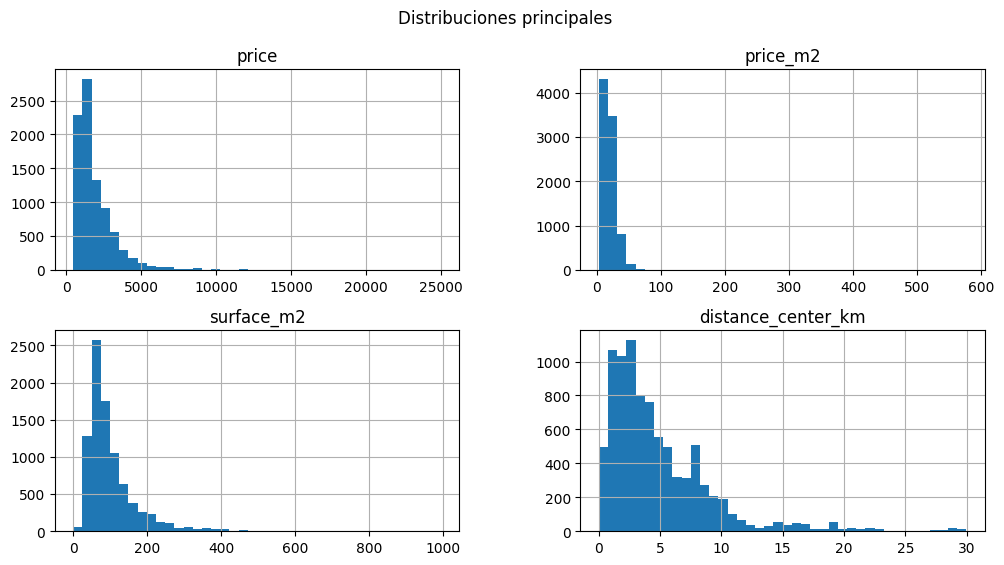

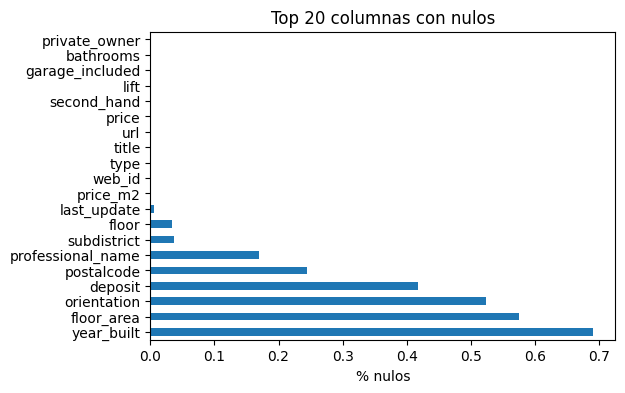

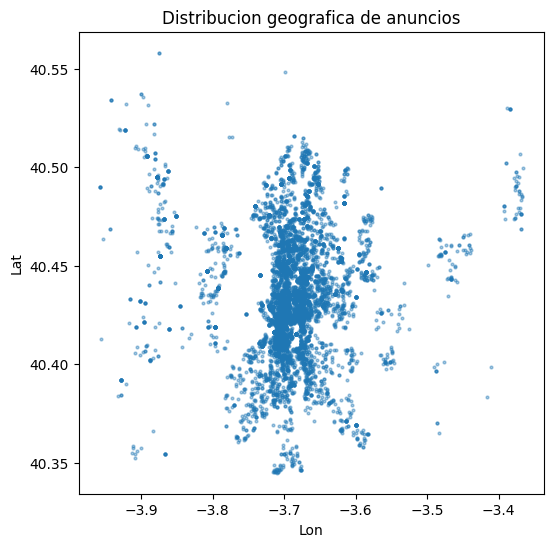

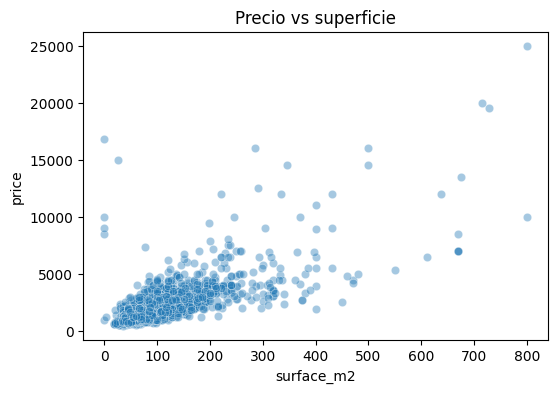

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribuciones basicas de numericas clave
numeric_cols = [c for c in ["price", "price_m2", "surface_m2", "distance_center_km"] if c in rent_df.columns]
if numeric_cols:
    plot_df = rent_df[numeric_cols].replace([np.inf, -np.inf], np.nan)
    plot_df.hist(figsize=(12, 6), bins=40)
    plt.suptitle("Distribuciones principales")
    plt.show()

# Top columnas con mayor missingness
missing = rent_df.isna().mean().sort_values(ascending=False).head(20)
plt.figure(figsize=(6, 4))
missing.plot(kind="barh")
plt.title("Top 20 columnas con nulos")
plt.xlabel("% nulos")
plt.show()

# Dispersion geografica
if lat_col and lon_col:
    plt.figure(figsize=(6, 6))
    plt.scatter(rent_df[lon_col], rent_df[lat_col], s=4, alpha=0.4)
    plt.title("Distribucion geografica de anuncios")
    plt.xlabel("Lon")
    plt.ylabel("Lat")
    plt.show()

# Relacion precio vs superficie
if "price" in rent_df.columns and "surface_m2" in rent_df.columns and len(rent_df) > 0:
    sample = rent_df.sample(min(2000, len(rent_df)), random_state=SEED)
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=sample, x="surface_m2", y="price", alpha=0.4)
    plt.title("Precio vs superficie")
    plt.show()


## Conclusiones del Notebook 01 — Calidad de Datos

### ¿Que hemos conseguido?

Este notebook ha tomado los datos crudos de anuncios de alquiler en Madrid (scrapeados de Idealista) y los ha convertido en un **dataset limpio, validado y listo para modelar**. Es el cimiento sobre el que se construye todo el pipeline.

### Hallazgos principales

| Aspecto | Resultado | ¿Que significa? |
|---------|-----------|-----------------|
| **Fuente de datos** | Idealista (Madrid), con geolocalizacion lat/lon | Los datos vienen de la plataforma inmobiliaria mas grande de España, lo que da representatividad al mercado real |
| **Deduplicacion** | 0 duplicados (por `web_id`) | Cada anuncio tiene un identificador único y no hay repeticiones — el dataset ya venia limpio en este aspecto |
| **Superficie** | 5.291 valores de `surface_m2` rellenados con `floor_built` | Mas de la mitad de los pisos no tenian superficie util (`floor_area`), asi que usamos la superficie construida como fallback y lo marcamos con un flag (`surface_is_built`) para que el modelo pueda distinguirlos |
| **Outliers** | ~5.8% en precio, ~7.2% en superficie (IQR) | Un porcentaje bajo de valores extremos. No los eliminamos aquí — solo lo documentamos para que los modelos puedan decidir como tratarlos |
| **Filtrado geografico** | Radio ≤30 km desde Sol + percentiles 0.5%–99.5% en lat/lon | Eliminamos anuncios fuera de Madrid (errores de geolocalizacion o zonas demasiado alejadas) |
| **Holdout temporal** | 20% mas reciente, con 7 dias de gap | Los datos mas recientes se reservan para la evaluacion final. El gap de 7 dias evita que pisos actualizados el mismo dia aparezcan en train y test |
| **Target** | `price` (EUR/mes) | Confirmamos que la columna `price` representa el alquiler mensual |
| **Semilla** | `SEED=100432070` | Garantiza que cualquier ejecucion produzca exactamente los mismos resultados |

### ¿Que implica para los siguientes pasos?

- El dataset procesado (`artifacts/processed_rent`) contiene **~8.800 anuncios validos** con coordenadas, precio y superficie.
- El holdout temporal esta **blindado**: nunca se toca hasta la evaluacion final.
- La columna temporal (`last_update`) solo tiene dia/mes sin año — asumimos 2025 y documentamos la limitacion.
- El parseo robusto con fallback regex garantiza que no se pierda informacion numérica por formatos mixtos.

### Artefactos generados

| Archivo | Proposito |
|---------|-----------|
| `artifacts/processed_rent.csv.gz` | Dataset limpio para todo el pipeline |
| `artifacts/splits/holdout_indices.npz` | Indices de train/holdout (inmutables) |
| `artifacts/splits/holdout_ids.csv` | Mapeo web_id → split (train/holdout) |
| `artifacts/data_dictionary.csv` | Reglas de normalizacion aplicadas |
| `reports/traceability_summary.md` | Origen y contexto de los datos |

### Siguiente paso
→ **NB02 (EDA)**: Explorar distribuciones, comparar precios por zona y detectar patrones espaciales.